# MSCA 32018 Natural Language Processing and Cognitive Computing
## Final Project - Entity Identification


Shijia Huang

-----

In [1]:
#!pip install -r requirements.txt

In [2]:
# Import basic libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [4]:
# Import NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pprint import pprint
import string
from rake_nltk import Rake

import eli5
import pickle

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
spacy.prefer_gpu()
print(spacy.__version__)

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim as gensimvis
#import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

2023-05-20 11:38:12.871313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.5.2


In [5]:
# Import sklearn libraries
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [6]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


### Read New Articles with Sentiment Score

In [30]:
%%time

# GCP version
path = "gs://nlp-final-project-data/data/"
df_news = pd.read_parquet(path + 'news_sentiment.parquet', engine='pyarrow')
df_news.shape

CPU times: user 2min 55s, sys: 1min 36s, total: 4min 32s
Wall time: 8min 13s


(154283, 11)

In [31]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154283 entries, 0 to 154282
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154283 non-null  int64 
 1   date              154283 non-null  object
 2   cleaned title     154283 non-null  object
 3   cleaned text      154283 non-null  object
 4   title_tokens      154283 non-null  object
 5   title_lemmatized  154283 non-null  object
 6   text_tokens       154283 non-null  object
 7   text_lemmatized   154283 non-null  object
 8   title_keywords    154283 non-null  object
 9   text_keywords     154283 non-null  object
 10  sentiment         154283 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 12.9+ MB


In [32]:
df_news.head(2)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords,sentiment
0,1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai_robot]","[child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, ai_robot]","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, admin, latest, posts, admin, see, mansplaining, conferences, get, forestall, february, coronavirus, could, explode, overnight, like, italy, february, levi, strauss, marks, next, phase, corporate, paid, leave, policies, february, scientists, designed, artificially, clever, robotic, helped, youngsters, autism, spice, studying, social, talents, hope, era, may, future, help, others, developmental, dysfunction, learn, ...","[child, autism, see, learn, social, skill, boost, play, robot, late, post, admin, see, mansplaining, conference, get, explode, overnight, mark, next, phase, corporate, pay, leave, policy, scientist, design, artificially, clever, robotic, help, youngster, autism, spice, study, social, talent, era, future, help, other, developmental, dysfunction, learn, notice, youngster, gentle, average, autism, take, domestic, s, refer, socially, assistive, robotic, name, kiwi, month, accord, commentary, way...","[social, skill, see, play, learn, child, boost, autism, robot, ai_robot]","[robotic, youngster, kid, child, kiwi, market, autism, learn, crew, talent]",5
1,2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus","Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, world, entered, new, era, accelerated, transformation, last, eighteen, months, continue, evolve, press, forward, years, come, businesses, playing, catchup, trying, make, sense, new, timeline, ten, years, set, aside, careful, planning, implementation, coming, next, longer, exists, next, happening, regardless, industry, seniority, status, quo, shifted, better, face, back, invited, attend, pompous, meeting, london, brazilian, embassy, along, selec...","[forget, ai, industry, obsolescence, focus, world, enter, new, era, accelerate, transformation, last, month, continue, evolve, press, forward, year, come, business, play, catchup, try, make, sense, new, timeline, year, set, aside, careful, planning, implementation, come, next, long, exist, ne

In [33]:
### SAMPLE DATA
#df_news = df_news.sample(frac=0.01, random_state=42)
df_news.shape

(154283, 11)

In [11]:
# remove links and special characters
def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'&\S+', '', text)
    text =  re.sub(r'\S+.com', '', text)
    text =  re.sub(r'\S+.ca', '', text)
    text =  re.sub(r'\S+.org', '', text)
    text = re.sub(r'[^a-zA-Z0-9 @ . , : - _]', '', text)
    return text

In [12]:
# clean the text
df_news['cleaned text'] = df_news['cleaned text'].apply(lambda x: remove_links(x))

## Identify Entities from News Text

In [13]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [14]:
from utils import process_text, process_text_sen
nlp = spacy.load('en_core_web_lg')

### NER with Sentence Segmentation 

In [15]:
# function to extract entities from news text with sentence segmentation
def extract_entities_sen(df):
    with mp.Pool() as pool:
        results = pool.imap_unordered(process_text_sen, df['cleaned text'], chunksize=2000)
        for i, ents in enumerate(results):
            for ent in ents:
                yield df.iloc[i]['id'], ent[0], ent[1]

In [16]:
%%time

ner_spacy_ntext_sen_df = pd.DataFrame(extract_entities_sen(df_news), columns=['id', 'Entities', 'Labels'])
ner_spacy_ntext_sen_df

CPU times: user 37min 36s, sys: 7.28 s, total: 37min 43s
Wall time: 1h 27min 10s


,id,Entities,Labels
0,1,Adobe,ORG
1,1,Firefly,ORG
2,1,AI,ORG
3,1,Summit Adobe,ORG
4,1,AI,ORG
...,...,...,...
12012051,200329,40.00,CARDINAL
12012052,200329,The Goldman Sachs Group,ORG
12012053,200329,Goldman Sachs Group,ORG
12012054,200329,Trims Latham Group NASDAQ,ORG


In [35]:
%%time

# save dataframe to csv

path = "gs://nlp-final-project-data/result/"
ner_spacy_ntext_sen_df.to_csv(path + 'ner_spacy_ntext_sen_df.csv', index=False)

## Reload the data

In [110]:
%%time

# reload dataframe from csv

path = "gs://nlp-final-project-data/result/"
ner_spacy_ntext_sen_df = pd.read_csv(path + 'ner_spacy_ntext_sen_df.csv')
ner_spacy_ntext_sen_df.shape

CPU times: user 13.4 s, sys: 5.7 s, total: 19.1 s
Wall time: 59.4 s


(12012056, 3)

In [111]:
# group by entities and labels
ner_spacy_ntext_sen_df.groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)

,Entities,Labels,count
154794,AI,PRODUCT,433856
154792,AI,ORG,205510
344834,ChatGPT,ORG,136885
1242644,first,ORDINAL,81753
558778,Google,ORG,80971
565192,Gray Media Group,ORG,80039
1287398,one,CARDINAL,68249
772947,Microsoft,ORG,67475
1119313,US,GPE,58753
58949,2020,DATE,55387


In [112]:
ner_spacy_ntext_sen_df['Labels'].value_counts()

Labels
ORG            5144349
PERSON         1305342
DATE           1282291
CARDINAL       1243239
GPE            1180928
PRODUCT         747176
NORP            209234
TIME            147391
LOC             142986
ORDINAL         135032
FAC             125376
WORK_OF_ART     103062
MONEY            99520
EVENT            51453
LAW              37329
QUANTITY         28090
PERCENT          16073
LANGUAGE         13185
Name: count, dtype: int64

##### ORG

In [113]:
# filter only the entities labelled as organization and count the number of occurences
spacy_org_sen_top50 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'ORG'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(50)
spacy_org_sen_top50

,Entities,Labels,count
10621,AI,ORG,205510
127739,ChatGPT,ORG,136885
262136,Google,ORG,80971
266629,Gray Media Group,ORG,80039
375371,Microsoft,ORG,67475
651282,pabilities,ORG,34898
418410,OpenAI,ORG,32015
54776,Artificial Intelligence,ORG,31835
288970,IBM,ORG,25276
352928,ML,ORG,24115


In [114]:
# drop rows that does not make sense
spacy_org_sen_top50 = spacy_org_sen_top50.drop([651282, 2023, 266639, 266629, 160123, 654164, 388732, 494957, 653753, 266631, 142153, 645103, 120560, 628280, 655531, 66131, 544134, 494968, 455854, 23709, 158551])
spacy_org_sen_top50

,Entities,Labels,count
10621,AI,ORG,205510
127739,ChatGPT,ORG,136885
262136,Google,ORG,80971
375371,Microsoft,ORG,67475
418410,OpenAI,ORG,32015
54776,Artificial Intelligence,ORG,31835
288970,IBM,ORG,25276
352928,ML,ORG,24115
209693,Facebook,ORG,19353
392860,NVIDIA,ORG,19219


In [115]:
# extract and drop the entities that related to AI
AI_org = [10621, 127739, 54776, 352928, 355775, 84137, 54962, 229232, 229189, 21425]
spacy_org_sen_top50_dropped = spacy_org_sen_top50.drop(AI_org)
spacy_org_sen_top50_dropped

,Entities,Labels,count
262136,Google,ORG,80971
375371,Microsoft,ORG,67475
418410,OpenAI,ORG,32015
288970,IBM,ORG,25276
209693,Facebook,ORG,19353
392860,NVIDIA,ORG,19219
43318,Amazon,ORG,17679
264420,Googles,ORG,14072
49643,Apple,ORG,12477
571535,Twitter,ORG,11906


##### PERSON

In [116]:
# filter only the entities labelled as person and count the number of occurences
spacy_peo_sen_top50 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'PERSON'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(50)
spacy_peo_sen_top50

,Entities,Labels,count
148876,Musk,PERSON,9396
66386,Elon Musk,PERSON,8613
29312,Bing,PERSON,8556
28432,Biden,PERSON,5514
195091,Size,PERSON,4935
213019,Trump,PERSON,3828
184544,Sam Altman,PERSON,3463
37390,CaptioningAudio,PERSON,2877
201900,Sundar Pichai,PERSON,2848
165706,Pichai,PERSON,2568


In [117]:
# drop rows that does not make sense
spacy_peo_sen_top50 = spacy_peo_sen_top50.drop([195091, 37390, 45889, 250718, 129749, 246489, 241425, 168619, 253389, 23813])
spacy_peo_sen_top50

,Entities,Labels,count
148876,Musk,PERSON,9396
66386,Elon Musk,PERSON,8613
29312,Bing,PERSON,8556
28432,Biden,PERSON,5514
213019,Trump,PERSON,3828
184544,Sam Altman,PERSON,3463
201900,Sundar Pichai,PERSON,2848
165706,Pichai,PERSON,2568
8493,Ai Weiwei,PERSON,2184
104222,Joe Biden,PERSON,2063


In [118]:
# extract and drop the entities that related to AI and Organization
AI_peo = [29312, 217077, 68936, 25246, 222242, 121003, 85932]
ORG_peo = [198057, 96034, 206723, 156807]
spacy_peo_sen_top50_dropped = spacy_peo_sen_top50.drop(AI_peo)
spacy_peo_sen_top50_dropped = spacy_peo_sen_top50_dropped.drop(ORG_peo)
spacy_peo_sen_top50_dropped

,Entities,Labels,count
148876,Musk,PERSON,9396
66386,Elon Musk,PERSON,8613
28432,Biden,PERSON,5514
213019,Trump,PERSON,3828
184544,Sam Altman,PERSON,3463
201900,Sundar Pichai,PERSON,2848
165706,Pichai,PERSON,2568
8493,Ai Weiwei,PERSON,2184
104222,Joe Biden,PERSON,2063
12925,Altman,PERSON,1859


##### GPE

In [119]:
# filter only the entities labelled as location and count the number of occurences
spacy_loc_sen_top50 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'GPE'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(50)
spacy_loc_sen_top50

,Entities,Labels,count
39615,US,GPE,58753
39493,U.S.,GPE,43312
7597,China,GPE,40462
28556,PRNewswire,GPE,39503
16859,India,GPE,38785
39568,UK,GPE,21448
17797,Japan,GPE,18671
6758,Canada,GPE,14105
50413,st,GPE,13293
51472,the United States,GPE,12591


In [120]:
# drop rows that does not make sense
spacy_loc_sen_top50 = spacy_loc_sen_top50.drop([28556, 50413, 720])
spacy_loc_sen_top50

,Entities,Labels,count
39615,US,GPE,58753
39493,U.S.,GPE,43312
7597,China,GPE,40462
16859,India,GPE,38785
39568,UK,GPE,21448
17797,Japan,GPE,18671
6758,Canada,GPE,14105
51472,the United States,GPE,12591
12831,France,GPE,12234
3291,Australia,GPE,11455


##### PRODUCT

In [121]:
# filter only the entities labelled as product and count the number of occurences
spacy_pro_sen_top50 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'PRODUCT'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(50)
spacy_pro_sen_top50

,Entities,Labels,count
2328,AI,PRODUCT,433856
5399,AIdriven,PRODUCT,7938
9728,Bing,PRODUCT,6707
24033,HPC,PRODUCT,2586
11393,CRM,PRODUCT,2226
19778,Excel,PRODUCT,1825
15723,Cresta,PRODUCT,1624
48202,Windows,PRODUCT,1574
1988,A.I.,PRODUCT,1424
7046,Akismet,PRODUCT,1412


In [122]:
# extract and the entities that related to AI
AI_pro = [2328, 9728, 24033, 15723, 1988, 7046, 43955, 23448, 2192, 2007, 26319, 13300, 16257, 39474, 14921, 26436, 41757, 28816]
ORG_pro = [16808, 35255, 13968, 6651, 10713, 44103, 16857, 38921]

#### Merge the results

In [123]:
# combine all AI entities
AI_entities = pd.concat([spacy_org_sen_top50[spacy_org_sen_top50.index.isin(AI_org)], spacy_peo_sen_top50[spacy_peo_sen_top50.index.isin(AI_peo)], spacy_pro_sen_top50[spacy_pro_sen_top50.index.isin(AI_pro)]], axis=0)
AI_entities

,Entities,Labels,count
10621,AI,ORG,205510
127739,ChatGPT,ORG,136885
54776,Artificial Intelligence,ORG,31835
352928,ML,ORG,24115
355775,Machine Learning,ORG,17099
84137,Bard,ORG,14528
54962,Artificial Intelligence AI,ORG,14382
229232,GPT3,ORG,8427
229189,GPT,ORG,7565
21425,AIgenerated,ORG,6998


In [124]:
# drop words like AI that is too general
AI_index = [10621, 54776, 54962, 2328]
AI_entities = AI_entities.drop(AI_index)
AI_entities

,Entities,Labels,count
127739,ChatGPT,ORG,136885
352928,ML,ORG,24115
355775,Machine Learning,ORG,17099
84137,Bard,ORG,14528
229232,GPT3,ORG,8427
229189,GPT,ORG,7565
21425,AIgenerated,ORG,6998
29312,Bing,PERSON,8556
217077,Vectorspace AI,PERSON,1784
68936,Ernie Bot,PERSON,1705


In [125]:
# combine all Organization entities
ORG_entities = pd.concat([spacy_org_sen_top50_dropped, spacy_peo_sen_top50[spacy_peo_sen_top50.index.isin(ORG_peo)], spacy_pro_sen_top50[spacy_pro_sen_top50.index.isin(ORG_pro)]], axis=0)
ORG_entities

,Entities,Labels,count
262136,Google,ORG,80971
375371,Microsoft,ORG,67475
418410,OpenAI,ORG,32015
288970,IBM,ORG,25276
209693,Facebook,ORG,19353
392860,NVIDIA,ORG,19219
43318,Amazon,ORG,17679
264420,Googles,ORG,14072
49643,Apple,ORG,12477
571535,Twitter,ORG,11906


In [126]:
%%time

# save the entities to csv
path = "gs://nlp-final-project-data/result/"
AI_entities.to_csv(path + 'AI_entities.csv', index=False)
ORG_entities.to_csv(path + 'ORG_entities.csv', index=False)

CPU times: user 22.3 ms, sys: 17.6 ms, total: 39.9 ms
Wall time: 1.36 s


#### Visualize the Entities

/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


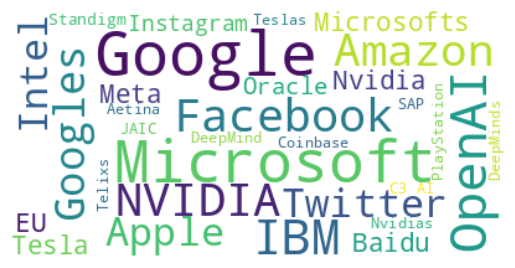

In [127]:
# Wordcloud for Organization entities

from wordcloud import WordCloud

word_counts = ORG_entities.set_index('Entities')['count'].apply(np.sqrt).to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


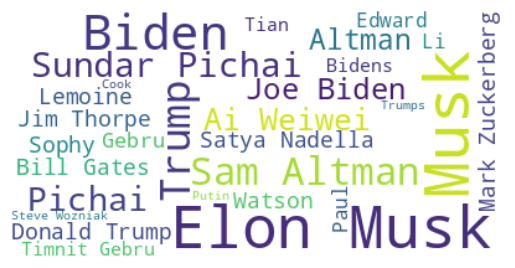

In [128]:
# Wordcloud for Person entities

word_counts = spacy_peo_sen_top50_dropped.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


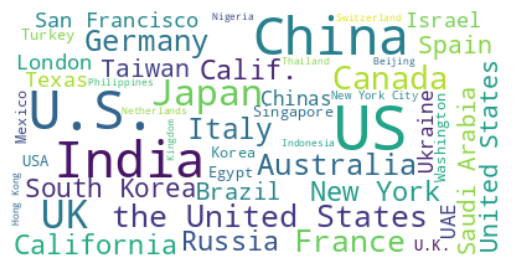

In [129]:
# Wordcloud for Location entities

word_counts = spacy_loc_sen_top50.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


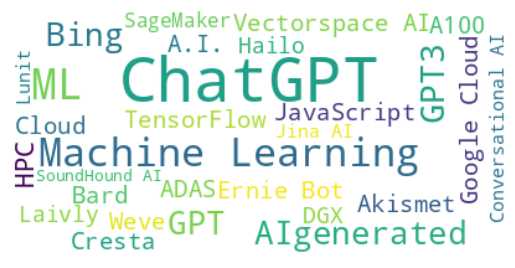

In [130]:
# Wordcloud for AI entities

word_counts = AI_entities.set_index('Entities')['count'].apply(np.sqrt).to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Timeline of the Introduction of AI in News Articles

In [131]:
len(AI_entities)

31

In [132]:
AI_entities_list = AI_entities['Entities'].tolist()
AI_entities_list

['ChatGPT',
 'ML',
 'Machine Learning',
 'Bard',
 'GPT3',
 'GPT',
 'AIgenerated',
 'Bing',
 'Vectorspace AI',
 'Ernie Bot',
 'Bard',
 'Weve',
 'Laivly',
 'Hailo',
 'Bing',
 'HPC',
 'Cresta',
 'A.I.',
 'Akismet',
 'TensorFlow',
 'Google Cloud',
 'ADAS',
 'A100',
 'JavaScript',
 'Cloud',
 'DGX',
 'SageMaker',
 'Conversational AI',
 'Jina AI',
 'Lunit',
 'SoundHound AI']

In [133]:
# filter the ner results and only keep the rows where the entities are in the AI_entities_list
AI_ner = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Entities'].isin(AI_entities_list)]
AI_ner

,id,Entities,Labels
424,8,AIgenerated,ORG
502,9,AIgenerated,ORG
514,9,AIgenerated,ORG
992,15,DGX,ORG
993,15,A100,PRODUCT
...,...,...,...
12011488,200317,GPT,ORG
12011690,200322,ChatGPT,ORG
12011700,200322,GPT,ORG
12011811,200324,AIgenerated,ORG


In [134]:
# merge the list of news dataframe with date column
df_news_date = df_news[['id', 'date']]
df_news_date

,id,date
0,1,2020-02-27
1,2,2021-03-26
2,3,2021-03-10
3,4,2020-10-20
4,5,2020-04-17
...,...,...
154278,200322,2021-11-17
154279,200323,2022-03-16
154280,200324,2023-03-01
154281,200328,2020-04-15


In [214]:
AI_ner_date = pd.merge(AI_ner, df_news_date, on='id', how='left')
AI_ner_date

,id,Entities,Labels,date
0,8,AIgenerated,ORG,2020-06-23
1,9,AIgenerated,ORG,2020-06-14
2,9,AIgenerated,ORG,2020-06-14
3,15,DGX,ORG,2020-02-19
4,15,A100,PRODUCT,2020-02-19
...,...,...,...,...
274680,200317,GPT,ORG,2021-11-22
274681,200322,ChatGPT,ORG,2021-11-17
274682,200322,GPT,ORG,2021-11-17
274683,200324,AIgenerated,ORG,2023-03-01


In [215]:
# select the rows where entities only occur less than 5 times in each article
AI_ner_date = AI_ner_date.groupby(['id', 'Entities']).filter(lambda x: len(x) >= 5)
AI_ner_date

,id,Entities,Labels,date
6,21,Bing,PRODUCT,2020-04-25
7,21,Bing,PRODUCT,2020-04-25
8,21,Bing,PRODUCT,2020-04-25
9,21,Bing,PERSON,2020-04-25
10,21,Bing,PERSON,2020-04-25
...,...,...,...,...
274656,200279,ChatGPT,ORG,2022-11-30
274657,200279,ChatGPT,ORG,2022-11-30
274658,200279,ChatGPT,ORG,2022-11-30
274659,200279,ChatGPT,ORG,2022-11-30


In [216]:
AI_ner_date.head(20)

,id,Entities,Labels,date
6,21,Bing,PRODUCT,2020-04-25
7,21,Bing,PRODUCT,2020-04-25
8,21,Bing,PRODUCT,2020-04-25
9,21,Bing,PERSON,2020-04-25
10,21,Bing,PERSON,2020-04-25
11,21,Bing,PRODUCT,2020-04-25
12,21,Bing,PERSON,2020-04-25
13,21,Bing,PRODUCT,2020-04-25
16,21,Bing,PERSON,2020-04-25
17,21,Bing,PERSON,2020-04-25


In [217]:
# get the article count of AI entities by date
AI_ner_date_count = AI_ner_date.groupby(['id', 'date', 'Entities']).size().reset_index().rename(columns={0:'count'}).sort_values('date', ascending=True)
AI_ner_date_count

,id,date,Entities,count
13567,142963,2020-01-01,ChatGPT,6
2151,23108,2020-01-01,ChatGPT,7
11224,118325,2020-01-02,SageMaker,9
17135,179442,2020-01-02,Machine Learning,6
14594,153635,2020-01-02,ChatGPT,13
...,...,...,...,...
12337,130414,2023-04-28,GPT,8
5919,61781,2023-04-28,ChatGPT,5
13053,137788,2023-04-28,Cresta,16
3690,38449,2023-04-28,ChatGPT,29


In [218]:
AI_ner_date_count = AI_ner_date_count.groupby(['date', 'Entities']).agg({'count': 'sum'}).reset_index()
AI_ner_date_count

,date,Entities,count
0,2020-01-01,ChatGPT,13
1,2020-01-02,Bard,28
2,2020-01-02,Bing,6
3,2020-01-02,ChatGPT,75
4,2020-01-02,ML,18
...,...,...,...
6000,2023-04-28,Hailo,5
6001,2023-04-28,Lunit,16
6002,2023-04-28,ML,87
6003,2023-04-28,Machine Learning,18


### Introduction of AI in News Articles

In [219]:
# earliest date for each entity
AI_ner_date_count.groupby('Entities')['date'].min().reset_index().rename(columns={'date':'earliest date'})

,Entities,earliest date
0,A.I.,2020-01-08
1,A100,2020-01-19
2,ADAS,2020-05-04
3,AIgenerated,2020-01-05
4,Bard,2020-01-02
5,Bing,2020-01-02
6,ChatGPT,2020-01-01
7,Cloud,2021-02-16
8,Conversational AI,2020-01-14
9,Cresta,2020-01-06


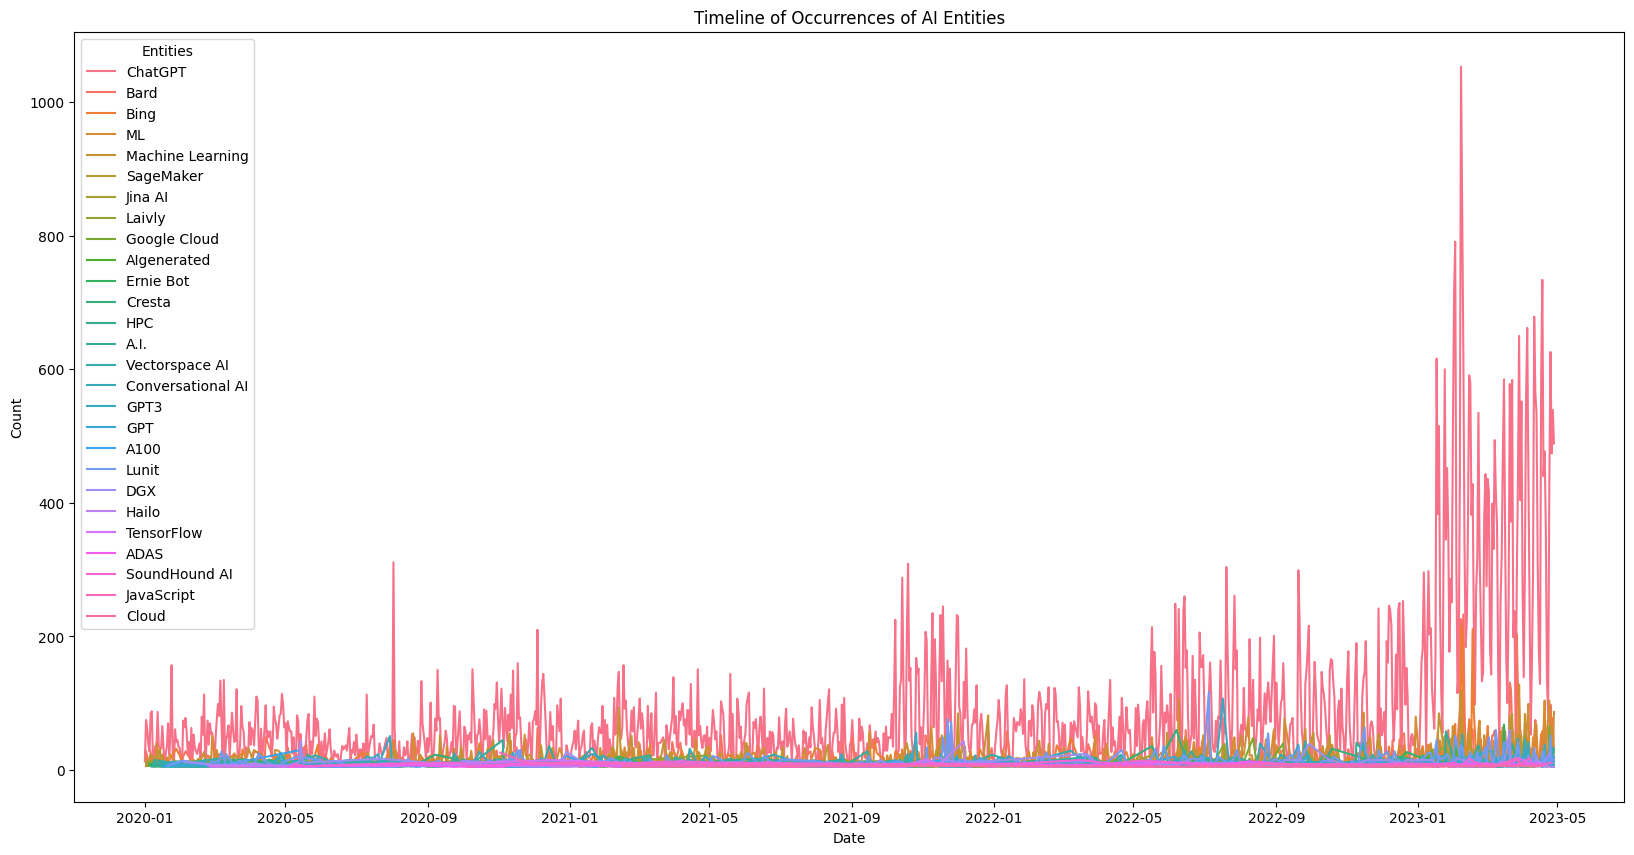

In [220]:
# timeline of occurrences of chatgpt
plt.figure(figsize=(20,10))
sns.lineplot(data=AI_ner_date_count, x='date', y='count', hue='Entities')
plt.title('Timeline of Occurrences of AI Entities')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

### Most Popular Discussed

In [221]:
# get the date for each entity where the count is the highest
max_counts = AI_ner_date_count.groupby('Entities')['count'].max()

AI_ner_max_date = AI_ner_date_count.loc[AI_ner_date_count.groupby('Entities')['count'].idxmax(), ['Entities', 'date']].sort_values('date').reset_index(drop=True)

AI_ner_max_date

,Entities,date
0,A100,2020-05-14
1,JavaScript,2020-11-02
2,Vectorspace AI,2021-01-20
3,Cloud,2021-11-02
4,Jina AI,2021-11-22
5,Hailo,2021-12-06
6,ADAS,2022-05-19
7,Cresta,2022-06-07
8,Lunit,2022-07-05
9,GPT3,2022-07-17


In [222]:
AI_ner_max_date.dtypes

Entities    object
date        object
dtype: object

In [223]:
# convert date to datetime
AI_ner_max_date['date'] = pd.to_datetime(AI_ner_max_date['date'])
AI_ner_max_date.dtypes

Entities            object
date        datetime64[ns]
dtype: object

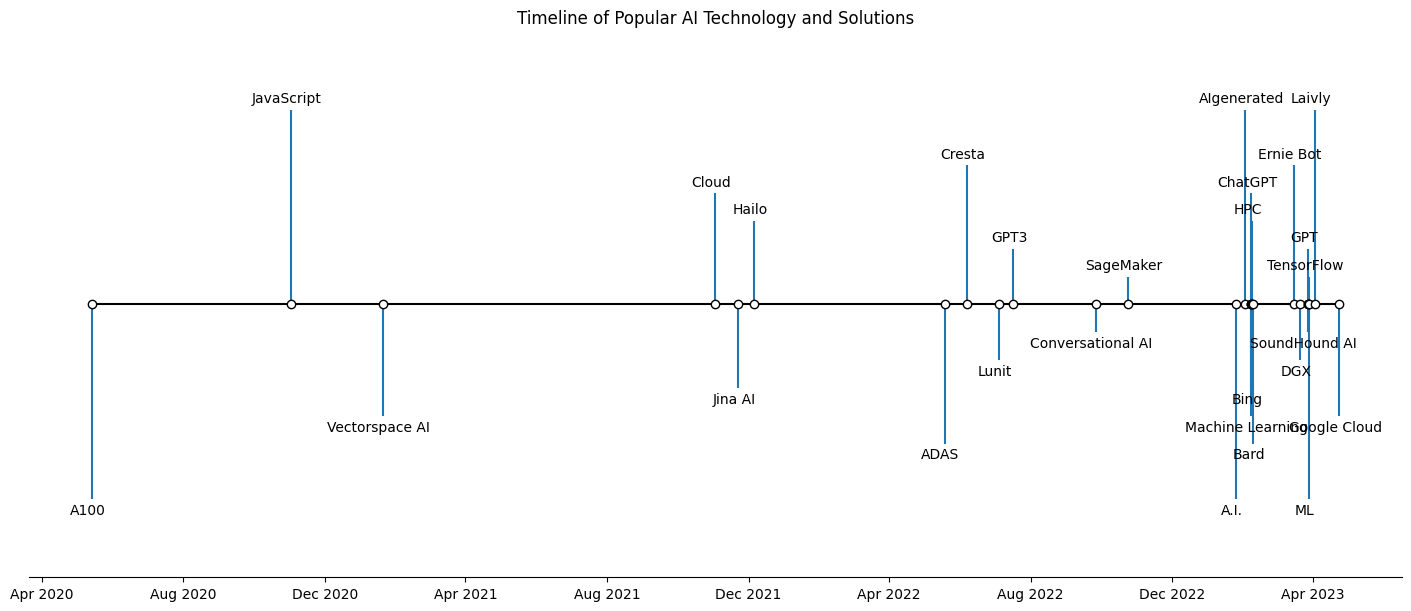

In [224]:
# plot the timeline
import matplotlib.dates as mdates
from datetime import datetime

# Choose some nice levels
levels = np.tile([-14, 14, -8, 8, -6, 6, -10, 10, -4, 4, -2, 2],
                 int(np.ceil(len(AI_ner_max_date['date'])/12)))[:len(AI_ner_max_date['date'])]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(14, 6), layout="constrained")
ax.set(title="Timeline of Popular AI Technology and Solutions")

ax.vlines(AI_ner_max_date['date'], 0, levels, color="tab:blue")  # The vertical stems.
ax.plot(AI_ner_max_date['date'], np.zeros_like(AI_ner_max_date['date']), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(AI_ner_max_date['date'], levels, AI_ner_max_date['Entities']):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l > 0 else "top")

# format x-axis with 4-month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
#plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.2)
plt.show()